In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [4]:
from world_models.dmc_cartpole_wrapper import DMCCartPoleWrapper

Gymnasium not available, creating mock spaces


In [5]:
env = DMCCartPoleWrapper()

In [233]:
num_samples = 50000

state = env.reset()
print(state)

inp_data = np.zeros((num_samples, 6))
outp_data = np.zeros((num_samples, 6))

print(dir(env.action_space))
for i in range(num_samples):
    action = np.random.uniform(low=env.action_space.low, high=env.action_space.high, size=(1,))
    inp_data[i,:5] = state
    inp_data[i,5] = action[0]
    next_state, reward, terminated, info = env.step(action)
    outp_data[i,:5] = next_state
    # print(type(reward))
    outp_data[i,5] = reward[0] #if not np.any(np.isnan(reward)) else 0.
    # print(state, action, next_state, reward)
    state = np.copy(next_state)
    
    

[[ 0.00351321 -0.99998976 -0.00452498  0.00259607 -0.01144985]]
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'high', 'low', 'shape']


In [234]:
print(np.min(outp_data, axis=0))
print(np.max(outp_data, axis=0))


[-1.90320108e+00 -9.99999996e-01 -9.99999998e-01 -3.52311622e+00
 -1.43482282e+01  9.73515770e-10]
[ 1.9113772   1.          1.          3.62889144 14.1034522   0.99661625]


In [236]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, output, target):
        # Calculate the squared differences
        squared_diff = (output - target) ** 2
        
        # Apply weights to the squared differences
        weighted_squared_diff = squared_diff * self.weights
        
        # Calculate the mean of the weighted squared differences
        loss = weighted_squared_diff.mean()
        return loss

def train_model(model, dataset, batch_size=32, num_epochs=100, learning_rate=0.001, validation_split=0.2):
    """
    Train a PyTorch model that maps vectors to vectors.

    Parameters:
    - model: The PyTorch model to train.
    - dataset: A tuple (X, y) where X is the input vectors and y is the target vectors.
    - batch_size: Number of samples per batch.
    - num_epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.
    - validation_split: Fraction of the dataset to use for validation.

    Returns:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    """
    
    # Unpack dataset
    X, y = dataset
    
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)

    # Create DataLoader for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                                   torch.tensor(y_train, dtype=torch.float32))
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                                                 torch.tensor(y_val, dtype=torch.float32))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
    # criterion = WeightedMSELoss(torch.tensor([1,1,200,50,1,1]))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate loss

        

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loss computation
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0.0
        
        with torch.no_grad():  # No gradient computation during validation
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader.dataset)

        scheduler.step(epoch_val_loss)
        
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses, val_dataset

In [237]:
# class SimpleModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(SimpleModel, self).__init__()
#         self.fc = nn.Linear(input_dim, output_dim)

#     def forward(self, x):
#         return self.fc(x)

class SimpleModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)  # Hidden layer
        self.relu = nn.ReLU()  # ReLU activation
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        x = self.hidden(x)  # Pass through hidden layer
        x = self.relu(x)    # Apply ReLU activation
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)  # Pass through output layer
        return x

# Create model
# model = SimpleModel(input_dim=inp_data.shape[1], output_dim=outp_data.shape[1])

model = SimpleModel(input_dim=inp_data.shape[1], hidden_dim=1000, output_dim=outp_data.shape[1])

from IPython.display import YouTubeVideo

# # Replace 'VIDEO_ID' with the actual ID of the YouTube video
# video_id = 'VBlFHuCzPgY'  # Example video ID
# YouTubeVideo(video_id, width=800, height=450, autoplay=1)

# # <iframe width="996" height="747" src="https://www.youtube.com/embed/VBlFHuCzPgY" title="Elevator Music - 1 hour" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

# Train the model
num_examples = 50000
train_losses, val_losses, val_dataset = train_model(model, (inp_data[:num_examples,:], outp_data[:num_examples,:]), batch_size=512, num_epochs=200, learning_rate=0.001)


Epoch [1/200], Train Loss: 0.1503, Val Loss: 0.0035
Epoch [2/200], Train Loss: 0.0026, Val Loss: 0.0023
Epoch [3/200], Train Loss: 0.0020, Val Loss: 0.0019
Epoch [4/200], Train Loss: 0.0022, Val Loss: 0.0023
Epoch [5/200], Train Loss: 0.0020, Val Loss: 0.0022
Epoch [6/200], Train Loss: 0.0020, Val Loss: 0.0021
Epoch [7/200], Train Loss: 0.0023, Val Loss: 0.0022
Epoch [8/200], Train Loss: 0.0021, Val Loss: 0.0031
Epoch [9/200], Train Loss: 0.0019, Val Loss: 0.0017
Epoch [10/200], Train Loss: 0.0018, Val Loss: 0.0034
Epoch [11/200], Train Loss: 0.0022, Val Loss: 0.0025
Epoch [12/200], Train Loss: 0.0020, Val Loss: 0.0026
Epoch [13/200], Train Loss: 0.0017, Val Loss: 0.0022
Epoch [14/200], Train Loss: 0.0016, Val Loss: 0.0014
Epoch [15/200], Train Loss: 0.0021, Val Loss: 0.0019
Epoch [16/200], Train Loss: 0.0016, Val Loss: 0.0027
Epoch [17/200], Train Loss: 0.0016, Val Loss: 0.0013
Epoch [18/200], Train Loss: 0.0017, Val Loss: 0.0015
Epoch [19/200], Train Loss: 0.0015, Val Loss: 0.0018
Ep

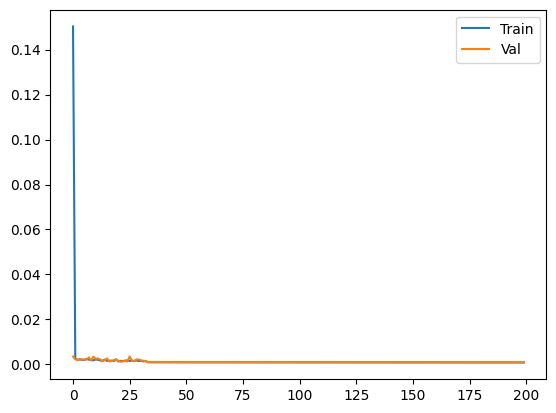

In [242]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()

In [243]:
X_test, y_test = val_dataset.tensors

In [244]:
y_hat = model(X_test)

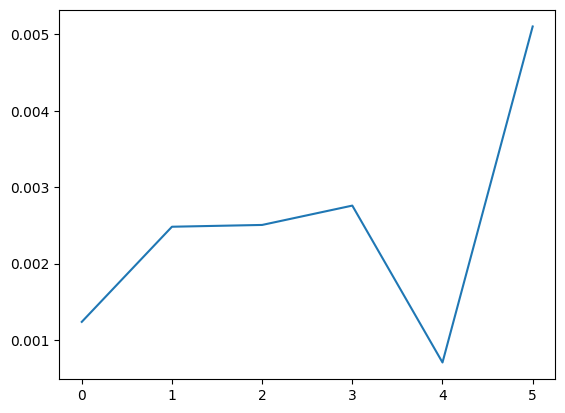

In [245]:
pred_error = y_test - y_hat

# plt.plot(np.divide(np.mean(pred_error.detach().numpy(), axis=0),np.mean(y_test.detach().numpy(), axis=0)))

abs_errs = np.abs(pred_error.detach().numpy())
abs_vals = np.abs(y_test.detach().numpy())
rel_err = np.mean(np.divide(abs_errs, abs_vals), axis=0)

# plt.figure()




# print(np.any(np.isnan(rel_err)))


# plt.figure()
value_range = np.abs(np.max(outp_data, axis=0) - np.min(outp_data, axis=0))
plt.plot(np.divide(np.mean(abs_errs, axis=0), value_range) )


In [246]:
torch.save(model, 'cartpole_world_model.pth')

In [247]:
!ls

agents			  networks     utils
cartpole_world_model.pth  README.md    visualize_and_evaluate.py
configs			  run_mbrl.py  world-model-learning.ipynb
environments		  runs	       world_models
learning		  testing
